In [106]:
import numpy as np

import typing
from typing import Any, Tuple

import einops

import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf

In [107]:
#@title
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [108]:
import numpy as np

def load_data(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.read().splitlines()
        pairs = [line.split('\t') for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])
    #geez_sentences = np.array([context for target, context in pairs])
    return target, context

path_to_file = 'oromic_geez_data_set.txt'
target_raw, context_raw = load_data(path_to_file)
print(context_raw[10])
print(target_raw[10])

አነ ቀደስኩ
jedheen isa galateeffadhe


In [109]:
from keras.preprocessing.text import Tokenizer
def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer()
    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [110]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [111]:
geezTokenizer = Tokenizer()
geezTokenizer.fit_on_texts(context_raw)
context_raw = geezTokenizer.texts_to_sequences(context_raw)

In [112]:
for example_context_strings, example_target_strings in train_raw.take(11):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break
    

tf.Tensor(
[b'\xe1\x8a\x96\xe1\x88\x8b\xe1\x8b\x8a\xe1\x88\x86\xe1\x88\x99 \xe1\x88\x88\xe1\x8a\xa5\xe1\x88\xb5\xe1\x88\xab\xe1\x8a\xa4\xe1\x88\x8d \xe1\x8a\xa0\xe1\x8d\x85\xe1\x88\x9d\xe1\x8a\xa5 \xe1\x8b\x98\xe1\x8b\xad\xe1\x88\xad\xe1\x8b\x95\xe1\x8b\xae\xe1\x88\x99 \xe1\x8a\xa8\xe1\x88\x98 \xe1\x8a\xa0\xe1\x89\xa3\xe1\x8c\x8d\xe1\x8b\x95 \xe1\x88\x88\xe1\x8b\xae\xe1\x88\xb4\xe1\x8d\x8d \xe1\x8b\x98\xe1\x8b\xad\xe1\x8a\x90\xe1\x89\xa5\xe1\x88\xad \xe1\x88\x8b\xe1\x8b\x95\xe1\x88\x88 \xe1\x8a\xaa\xe1\x88\xa9\xe1\x89\xa4\xe1\x88\x8d \xe1\x8a\xa0\xe1\x88\xb5\xe1\x89\xb0\xe1\x88\xad\xe1\x8a\xa0\xe1\x8b\xa8'
 b'\xe1\x89\xb5\xe1\x8c\x88\xe1\x89\xa5\xe1\x88\xad \xe1\x88\x98\xe1\x8a\x83\xe1\x89\xb5\xe1\x8b\x8a\xe1\x88\x83 \xe1\x88\xb5\xe1\x89\xa5\xe1\x8b\x93\xe1\x89\xb1 \xe1\x8b\x88\xe1\x89\xb5\xe1\x88\xa5\xe1\x88\xab\xe1\x8b\x95 \xe1\x88\x98\xe1\x8a\x83\xe1\x89\xb5\xe1\x8b\x88 \xe1\x8b\x88\xe1\x8b\xab\xe1\x88\xad\xe1\x8a\xa5\xe1\x8b\xa9 \xe1\x8a\xa5\xe1\x88\x9d\xe1\x8a\xa0\xe1\x88\x90\xe1\

In [113]:
example_text = tf.constant('አነ ቀደስኩ')

print(example_text.numpy().decode('utf-8'))
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy().decode('utf-8'))


አነ ቀደስኩ
አነ ቀደስኩ


In [114]:
import tensorflow as tf
import tensorflow_text as tf_text

example_text_ = tf.constant('feya dha')
example_text = tf.constant('አነ ቀደስኩ')
# Unicode normalization will be the first step in the text standardization function:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,]', ' \\0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    # Add the encoding and errors argument to the decode method

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

#print(example_text.numpy().decode())
#print(tf_lower_and_split_punct(example_text))
#print(tf_lower_and_split_punct(example_text_).numpy().decode())
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode('utf-8'))


አነ ቀደስኩ
[START]  [END]


In [115]:
# Text Vectorization
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]
# Here are the first 10 words from the vocabulary:
# Here are the first 10 words from the vocabulary:
#vocabulary = context_text_processor.get_vocabulary()
#first_10_words = vocabulary[:10].numpy()

['', '[UNK]', '[START]', '[END]']

In [116]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]


['', '[UNK]', '[START]', '[END]', 'fi', 'hin', 'isaa', 'kee', 'akka', 'ni']

In [117]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:5, :]


<tf.RaggedTensor [[2, 3],
 [2, 3],
 [2, 3],
 [2, 3],
 [2, 3]]>

In [118]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)


'[START] [END]'

Text(0.5, 1.0, 'Mask')

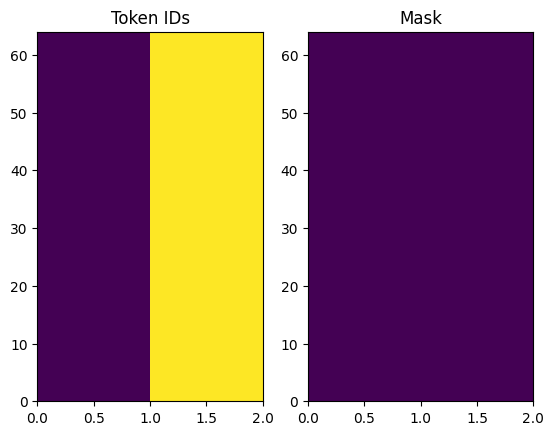

In [119]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')


In [120]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)


In [121]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_tar_in[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())


[2 3]

[   2 1178 3969    9 3476  349    0    0    0    0]
[1178 3969    9 3476  349    3    0    0    0    0]


In [122]:
UNITS = 256

In [123]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                      # Return the sequence and state
                                      return_sequences=True,
                                      recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context


try it out

In [124]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')


Context tokens, shape (batch, s): (64, 2)
Encoder output, shape (batch, s, units): (64, 2, 256)


The attention layer

In [125]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x


In [126]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')


Context sequence, shape (batch, s, units): (64, 2, 256)
Target sequence, shape (batch, t, units): (64, 30, 256)
Attention result, shape (batch, t, units): (64, 30, 256)
Attention weights, shape (batch, t, s):    (64, 30, 2)


In [127]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

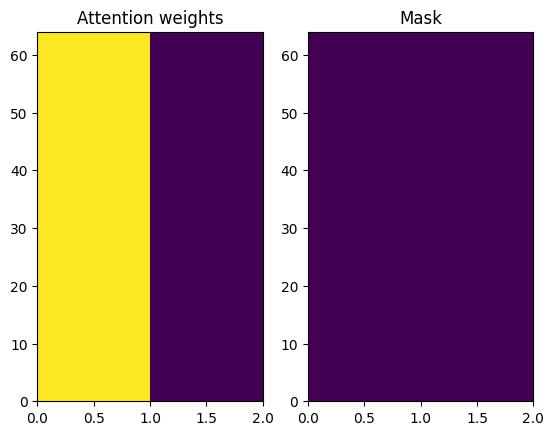

In [128]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


A unidirectional RNN

In [129]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)


training

In [130]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits


That will be sufficient for training. Create an instance of the decoder to test out:

In [131]:
decoder = Decoder(target_text_processor, UNITS)

In [132]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')


encoder output shape: (batch, s, units) (64, 2, 256)
input target tokens shape: (batch, t) (64, 30)
logits shape shape: (batch, target_vocabulary_size) (64, 30, 5000)


In [133]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]


In [134]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result


In [135]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True)

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state


In [136]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()


array([b'himate haadha bulcha funyoodhaan addaan gantummaadhaan elkaanaa jaalladha zabulon heenos',
       b'furuun ayyaanota awwaala waxii fidan haannaan mootichaas kaain kaasi galateeffadha',
       b'lubicha kutaa dhugu kamiinuu hoggantoota garboonni soomanaa saddeettama dhiirotaa dhundhuma'],
      dtype=object)

In [137]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                 context_text_processor,
                 target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits


In [138]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')


Context tokens, shape: (batch, s, units) (64, 2)
Target tokens, shape: (batch, t) (64, 30)
logits, shape: (batch, t, target_vocabulary_size) (64, 30, 5000)


In [139]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


In [140]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [141]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])


In [142]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}


{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [143]:
model.evaluate(val_ds, steps=20, return_dict=True)


20/20 [==============================] - 24s 470ms/step - loss: 8.5259 - masked_acc: 1.1347e-04 - masked_loss: 8.5259


{'loss': 8.525897026062012,
 'masked_acc': 0.00011347369581926614,
 'masked_loss': 8.525897026062012}

In [147]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/100
100/100 [==============================] - 101s 1s/step - loss: 2.9160 - masked_acc: 0.3844 - masked_loss: 2.9160 - val_loss: 5.3005 - val_masked_acc: 0.1846 - val_masked_loss: 5.3005
Epoch 2/100
100/100 [==============================] - 97s 974ms/step - loss: 2.6816 - masked_acc: 0.4274 - masked_loss: 2.6828 - val_loss: 5.4277 - val_masked_acc: 0.1883 - val_masked_loss: 5.4277
Epoch 3/100
100/100 [==============================] - 92s 919ms/step - loss: 2.4936 - masked_acc: 0.4625 - masked_loss: 2.4942 - val_loss: 5.6258 - val_masked_acc: 0.1746 - val_masked_loss: 5.6258
Epoch 4/100
100/100 [==============================] - 86s 862ms/step - loss: 2.3169 - masked_acc: 0.4949 - masked_loss: 2.3178 - val_loss: 5.7811 - val_masked_acc: 0.1775 - val_masked_loss: 5.7811
Epoch 5/100
100/100 [==============================] - 86s 859ms/step - loss: 2.1754 - masked_acc: 0.5226 - masked_loss: 2.1754 - val_loss: 5.8897 - val_masked_acc: 0.1747 - val_masked_loss: 5.8897
Epoch 6/100


In [145]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result


In [146]:

result = model.translate(['አነ ቀደስኩ']) # Are you still home
result[0].numpy().decode()


'waaqayyo immoo saamueliin dhaqiitii yaa gooftaa ati saba kee oolchitee warra [UNK] fi warra [UNK] qaban hunda caalaa [UNK] '